Split Learning Tutorial Part 2

Scope
Understanding the information
flow

Threat models for split Learning

Reconstructing input from activation

Setting up the attack pipeline

# Setup the standard single client Split Learning Pipeline

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.autograd import Variable

In [4]:
from matplotlib import pyplot as plt

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

#CIFAR 10 is a dataset of natural images consisting of 50k training images and 10k test
#Every image is labelled with one of the following class
classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

trainset = torchvision.datasets.CIFAR10(root='./data',train = True, download = True,transform = transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=128,shuffle= True,num_workers = 2)

testset = torchvision.datasets.CIFAR10(root = './data', train = False,download = True,transform = transform)
testloader = torch.utils.data.DataLoader(testset,batch_size = 128,shuffle = True,num_workers = 2)

100%|██████████| 170498071/170498071 [00:11<00:00, 14656995.99it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
class ResNet18Client(nn.Module):
    """ docstring for ResNet """
    #Explain initialize (listing the neural network architecture and other related parameters)
    def __init__(self,config):
        super(ResNet18Client,self).__init__()
        #Declare where we are going to split the NN, if cut layer close to output most computation will happen in the client side
        self.cut_layer = config["cut_layer"]

        #Load the resnet model
        self.model = models.resnet18(pretrained = False)
        self.model = nn.ModuleList(self.model.children())
        self.model = nn.Sequential(*self.model)

    def forward(self,x):
        for i,l in enumerate(self.model):
            if i> self.cut_layer:
                break
            x = l(x)
        return x

In [8]:
class ResNet18Server(nn.Module):
    """ docstring for ResNet """
    def __init__(self,config):
        super(ResNet18Server,self).__init__()
        self.logits = config["logits"]
        self.cut_layer = config["cut_layer"]

        self.model = models.resnet18(pretrained = False)
        num_ftrs = self.model.fc.in_features
        #
        self.model.fc = nn.Sequential(nn.Flatten(),nn.Linear(num_ftrs,self.logits))
        self.model = nn.ModuleList(self.model.children())
        self.model = nn.Sequential(*self.model)

    def forward(self,x):
        for i,l in enumerate(self.model):
            #continue until you are in the cut layer, skip earlier layers
            if i<=self.cut_layer:
                continue
            x = l(x)
        return nn.functional.softmax(x,dim=1)

In [9]:
config = {'cut_layer':5,"logits":10} #logits = 10 cause we are using ciphar10 that has 10 classes
client_model = ResNet18Client(config).to(device)
server_model = ResNet18Server(config).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [10]:
criterion = nn.CrossEntropyLoss()
client_optimizer = optim.SGD(client_model.parameters(),lr=0.01,momentum=0.9)
server_optimizer = optim.SGD(server_model.parameters(),lr=0.01,momentum = 0.9)

# Train the Split Learning Algorithm

In [11]:
num_epochs = 50
for epoch in range(num_epochs):
    running_loss = 0.0
    for i,data in enumerate(trainloader,0):
        inputs, labels = data[0].to(device), data[1].to(device)

        client_optimizer.zero_grad()
        server_optimizer.zero_grad()

        #Client Part
        activation = client_model(inputs)
        server_inputs = activation.detach().clone() # get the outputs of the client and input them to the server

        #Simulation of sever part is happening in this portion
        #Server part
        server_inputs = Variable(server_inputs,requires_grad = True)
        outputs = server_model(server_inputs)
        loss = criterion(outputs,labels)
        loss.backward()

        #Server optimization
        server_optimizer.step()

        #Simulation of Client Happening in this portion
        #Client optimization
        activation.backward(server_inputs.grad)
        client_optimizer.step()

        running_loss += loss.item()

        if i % 200 == 199:
            print("[{},{}] loss: {}".format(epoch+1,i+1,running_loss/200))


[1,200] loss: 2.1311393946409227
[2,200] loss: 1.9497339099645614
[3,200] loss: 1.8957899695634841
[4,200] loss: 1.8538223695755005
[5,200] loss: 1.8227546453475951
[6,200] loss: 1.8033118563890458
[7,200] loss: 1.775288780927658
[8,200] loss: 1.7597699129581452
[9,200] loss: 1.7473616653680801
[10,200] loss: 1.7290715277194977
[11,200] loss: 1.7161530756950378
[12,200] loss: 1.7095110654830932
[13,200] loss: 1.6913652205467224
[14,200] loss: 1.6798196315765381
[15,200] loss: 1.67042466878891
[16,200] loss: 1.6659546041488646
[17,200] loss: 1.6538252025842666
[18,200] loss: 1.6463520616292953
[19,200] loss: 1.6361530774831772
[20,200] loss: 1.6284865891933442
[21,200] loss: 1.625011283159256
[22,200] loss: 1.6248898613452911
[23,200] loss: 1.6123758071660996
[24,200] loss: 1.610771781206131
[25,200] loss: 1.602788160443306
[26,200] loss: 1.5968510860204697
[27,200] loss: 1.5928330296278
[28,200] loss: 1.586920541524887
[29,200] loss: 1.5808316624164582
[30,200] loss: 1.5772338849306107

#Measure the Test Set Performance

In [12]:
total, correct = 0, 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = server_model(client_model(inputs))
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()
    print(correct/total)

0.7316


#Understanding the Information flow by visualizing the activations

In [13]:
dataiter = iter(trainloader)
batch = next(dataiter)
images, labels = batch[0].to(device), batch[1].to(device)

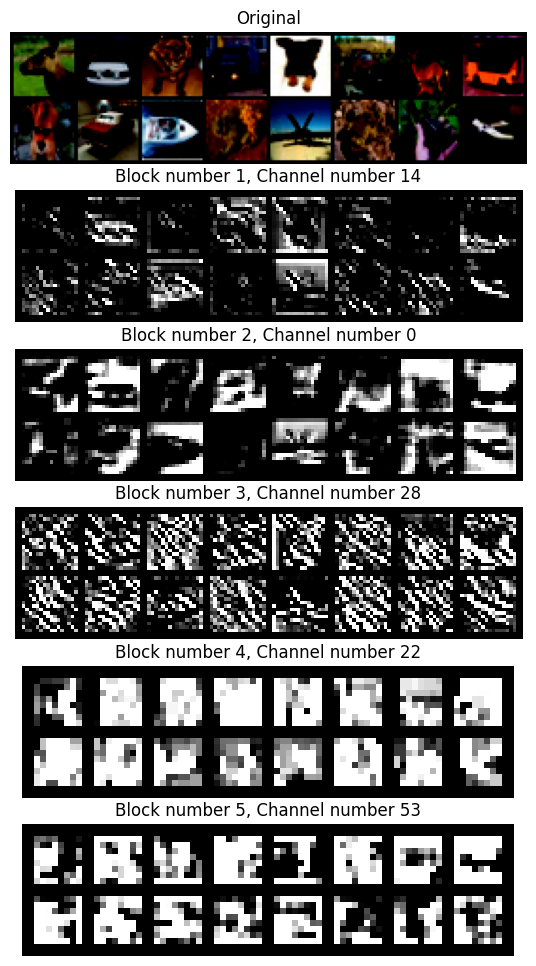

In [14]:
fig, axes = plt.subplots(6,1,figsize=(15,12))

axes[0].imshow(torchvision.utils.make_grid(images[0:16].cpu()).permute(1,2,0))
axes[0].axis('off')
axes[0].title.set_text("Original")
for layer_position in range(1,6):
    # Indices represent the layer position
    activations = client_model.model[:layer_position](images).detach()

    # Since there are many channels in the intermediate activations, we only visualize a random channel
    channel_index = torch.randint(0,64,(1,))
    axes[layer_position].imshow(torchvision.utils.make_grid(activations[0:16,channel_index].cpu()).permute(1,2,0)) #grayscale representation of block
    #axes[layer_position].imshow(torchvision.utils.make_grid(activations[0:16,channel_index-3:channel_index].cpu()).permute(1,2,0)) # fake RGB representation of block
    axes[layer_position].axis("off")
    axes[layer_position].title.set_text("Block number {}, Channel number {}".format(layer_position,channel_index.item()))

notes:
How much information can we extract from Z (intermediate state) about X, and how the information about X changes as we go deeper in the layers of the NN

#Threat Model


1.   Malicious Server with access to

    1a.  A dataset of pairs of activations and input samples
    
    1b. Client's network weights

Goal is to reconstruct the input sample, predict a sensitive attribute, membership inference etc.
Here we will focus on input sample reconstruction from the Z's.
Q: Given a Z how to reconstruct X.



#Reconstruction using Supervised Decoder Techniques
Train a generative model (decoder) to predict X' from Z such that Distance(X',X) is as minimum as possible.

In [59]:
def reconstruction_loss(img1,img2):
    return F.l1_loss(img1,img2)
    #return nn.L1Loss(img1,img2)

class ResnetBlock(nn.Module):
    """ Define a Resnet Block """

    def __init__(self,dim,padding_type,norm_layer,use_dropout,use_bias):
        """ Initialize Resnet Block
        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip conncetions in <forward> function.
        """
        super(ResnetBlock,self).__init__()
        self.conv_block = self.build_conv_block(dim,padding_type,norm_layer,use_dropout,use_bias)

    def build_conv_block(self,dim,padding_type,norm_layer,use_dropout,use_bias):
        """ Construct a convolutional block
        Parameters:
            dim(int)            -- the number of channels in the conv layer
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            nomr_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            use_bias (bool)     -- if the conv layer uses bias or not
        Returns a conv block
        """
        conv_block = []
        p =0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(2)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim,dim,kernel_size =3,padding=p,bias=use_bias),norm_layer(dim),nn.ReLU(True)]

        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(2)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim,dim,kernel_size =3,padding=p,bias=use_bias),norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self,x):
        out = x + self.conv_block(x)
        return out

class AdversaryModelGen(nn.Module):
    """
    """
    def __init__(self):
        super(AdversaryModelGen,self).__init__()
        input_nc = 64
        output_nc = 3
        ngf = 32
        use_bias = False
        n_blocks = 2
        use_dropout = False
        padding_type = 'reflect'
        norm_layer = nn.BatchNorm2d

        model = [
                nn.Conv2d(input_nc,ngf,kernel_size = 3,padding=1,bias = use_bias),
                norm_layer(ngf),
                nn.ReLU(True),
        ]
        n_downsampling = 2

        for i in range(n_downsampling):
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult,ngf*mult*2,kernel_size =3,stride =2,padding =1,bias= use_bias),
                        norm_layer(ngf*mult*2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf*mult,padding_type=padding_type,norm_layer = norm_layer,use_dropout=use_dropout,use_bias=use_bias)]

        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling-i)
            model += [nn.ConvTranspose2d(ngf *mult,int(ngf *mult / 2),kernel_size =3,stride=2,padding=1,output_padding =1,bias = use_bias),
                        norm_layer(int(ngf*mult/2)),nn.ReLU(True)]

        n_upsampling_extra = 2 - n_downsampling
        for i in range(n_upsampling_extra):
            model += [nn.ConvTranspose2d(ngf,ngf,kernel_size=3,stride=2,padding=1,
                                            output_padding=1,bias=use_bias),
                        norm_layer(ngf),nn.ReLU(True)]
            if False and i == 0:
                model += [nn.Conv2d(ngf,ngf,kernel_size =2,stride=1,padding=0),
                            norm_layer(ngf),nn.ReLU(True)]

        model += [nn.ConvTranspose2d(ngf,output_nc,kernel_size=3,stride=2,padding=1,output_padding=1,bias= use_bias)]
        self.m = nn.Sequential(*model)

    def forward(self,x):
        for l in self.m:
            x = l(x)
        return x


# Setup Reconstruction Pipeline

In [60]:
adv_model = AdversaryModelGen().to(device)
adv_optimizer = optim.SGD(adv_model.parameters(),lr=0.01,momentum = 0.9)

In [61]:
num_epochs = 50
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        inputs, labels = data[0].to(device), data[1].to(device)

        adv_optimizer.zero_grad()

        # Client Part
        activations = client_model.model[:1](inputs)
        server_inputs = activations.detach().clone()

        # Simulation of adversary part is happening in this portion
        server_inputs = Variable(server_inputs,requires_grad=True)
        outputs = adv_model(server_inputs)
        loss = reconstruction_loss(outputs,inputs)
        loss.backward()

        # Adversary model optimization
        adv_optimizer.step()

        running_loss += loss.item()

        if i % 200 == 199:
             print("[{},{}] loss: {}".format(epoch+1,i+1,running_loss/200))

[1,200] loss: 0.3162472715228796
[2,200] loss: 0.17305657610297204
[3,200] loss: 0.1496278939396143
[4,200] loss: 0.1375898376852274
[5,200] loss: 0.12870790682733058
[6,200] loss: 0.12304800771176815
[7,200] loss: 0.11876873187720775
[8,200] loss: 0.1158243015781045
[9,200] loss: 0.11264665447175502
[10,200] loss: 0.11053939118981361
[11,200] loss: 0.10770605191588402
[12,200] loss: 0.10439355757087469
[13,200] loss: 0.1026371942833066
[14,200] loss: 0.10054645888507366
[15,200] loss: 0.0987986958026886
[16,200] loss: 0.09696262650191784
[17,200] loss: 0.09541466858237982
[18,200] loss: 0.09472994655370712
[19,200] loss: 0.09300319191068411
[20,200] loss: 0.09260384999215603
[21,200] loss: 0.0917121821641922
[22,200] loss: 0.09075281996279955
[23,200] loss: 0.09074962232261896
[24,200] loss: 0.08962184373289346
[25,200] loss: 0.08905049718916416
[26,200] loss: 0.08837517365813255
[27,200] loss: 0.08832340233027935
[28,200] loss: 0.08698853615671397
[29,200] loss: 0.08731091029942036
[

# Visualization of the adversary model performance

In [62]:
dataiter = iter(testloader)
batch = next(dataiter)
images, labels = batch[0].to(device), batch[1].to(device)

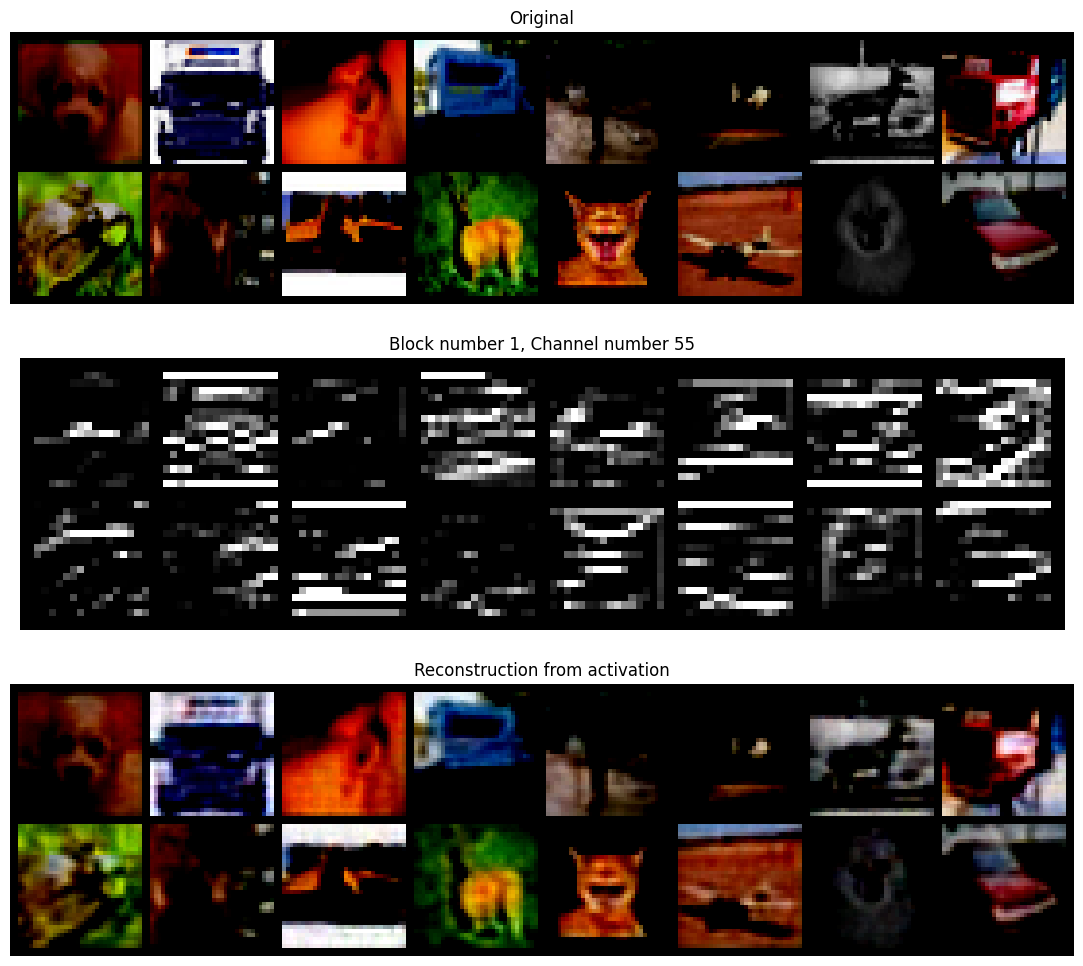

In [63]:
fig, axes = plt.subplots(3,1,figsize=(15,12))

axes[0].imshow(torchvision.utils.make_grid(images[0:16].cpu()).permute(1,2,0))
axes[0].axis('off')
axes[0].title.set_text("Original")

layer_position = 1
activations = client_model.model[:layer_position](images).detach()
channel_index = torch.randint(0,64,(1,))
axes[layer_position].imshow(torchvision.utils.make_grid(activations[0:16,channel_index].cpu()).permute(1,2,0)) #grayscale representation of block
axes[layer_position].axis("off")
axes[layer_position].title.set_text("Block number {}, Channel number {}".format(layer_position,channel_index.item()))

reconstruction = adv_model(activations).detach()
axes[2].imshow(torchvision.utils.make_grid(reconstruction[0:16].cpu()).permute(1,2,0)) #grayscale representation of block
axes[2].axis("off")
axes[2].title.set_text("Reconstruction from activation")
